# Topic Classification

The goal of this notebook is to solve the following questions regarding our research problem:

- Which topics are the most frequent in fake news?
- Is there any correlation between the topics? 
- Is there any difference in the sentiment score per topic?


In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex, re, sys, nltk
import nltk
import string
import geonamescache 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
gc = geonamescache.GeonamesCache()
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from pathlib import Path
src_path = str(Path.cwd().parent.parent.parent)
pd.options.mode.chained_assignment = None  # default='warn'

In [162]:
filepath = Path.cwd().parent.parent.parent / "WELFake_Dataset.csv"
df = pd.read_csv(filepath)
df.dtypes
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Data Preprocessing 

In order to get an structured and clean database to perform topic classification, some tasks for processing text should be performed. 

1. The first step is remove the rows with missing values in the column text. 
2. To avoid case sensitiveness, all the text is transformed to lower case

In [163]:
#Remove NaN in column text
df = df.dropna()
nan_value = float("NaN")
df.text.replace("", nan_value, inplace=True)
df['check']=df[['text']].applymap(lambda x: x=="")
df=df.loc[df['check']==False]
df.drop('check',axis=1,inplace=True)
# Apply lower case to avoid case sensitiviness
df['text']=df['text'].str.lower()
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,no comment is expected from barack obama membe...,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",a dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,all we can say on this one is it s about time ...,1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,washington (reuters) - hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"you know, because in fantasyland republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,migrants refuse to leave train at refugee camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,mexico city (reuters) - donald trump’s combati...,0


3. After doing some exploratory analysis, we decided to narrow our analysis to Reuters news for two reasons: first, the whole database of news is extremely large and it is time-processing demanding, and second, Reuters have a wide variety of topics which allow us to analyse the topics broadly. **We remain with 22,299 documents**



In [98]:
#select Reuters news -22,299
#df = df.loc[df['text'].str.contains("reuters")].reset_index(drop= True)
#df

4. As our goal is to identify most frequent topics in fake news, we select just the fake news of the dataset

### Data Preprocessing for Topic Classification

In [164]:
#select fake news
df_fake= df.loc[df['label']==1]
df_fake

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,no comment is expected from barack obama membe...,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"now, most of the demonstrators gathered last ...",1
4,4,SATAN 2: Russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,all we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,dr. ben carson tells the story of what happene...,1
...,...,...,...,...
72125,72125,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,1
72127,72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,an email released by wikileaks on sunday appea...,1
72128,72128,JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...,judge jeanine lets it rip! she s concerned wit...,1
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"you know, because in fantasyland republicans n...",1


5. In order to remove words that do not contribute much in the identification of the topic, we remove the stopwords as well as puntuaction. 

In [165]:
# Remove stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_fake['wo_stop'] = df_fake['text'].apply(lambda text: remove_stopwords(text))
#Remove punctuation
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_fake["wo_punct"] = df_fake["wo_stop"].apply(lambda text: remove_punctuation(text))
df_fake

,Unnamed: 0,title,text,label,wo_stop,wo_punct
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,no comment is expected from barack obama membe...,1,comment expected barack obama members #fyf911 ...,comment expected barack obama members fyf911 f...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"now, most of the demonstrators gathered last ...",1,"now, demonstrators gathered last night exercis...",now demonstrators gathered last night exercisi...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1,"rs-28 sarmat missile, dubbed satan 2, replace ...",rs28 sarmat missile dubbed satan 2 replace ss1...
5,5,About Time! Christian Group Sues Amazon and SP...,all we can say on this one is it s about time ...,1,say one time someone sued southern poverty law...,say one time someone sued southern poverty law...
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,dr. ben carson tells the story of what happene...,1,dr. ben carson tells story happened spoke obama:,dr ben carson tells story happened spoke obama
...,...,...,...,...,...,...
72125,72125,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,1,,
72127,72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,an email released by wikileaks on sunday appea...,1,email released wikileaks sunday appears show f...,email released wikileaks sunday appears show f...
72128,72128,JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...,judge jeanine lets it rip! she s concerned wit...,1,judge jeanine lets rip! concerned silencing co...,judge jeanine lets rip concerned silencing con...
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"you know, because in fantasyland republicans n...",1,"know, fantasyland republicans never questioned...",know fantasyland republicans never questioned ...


7. We removed the word "reuters" from the news since it is going to present accross all the articles. 
8. Finally, we proceed to clean the text by removing words that includes numbers as *10th* or complete numbers to avoid to have them in the DTM. 

In [198]:
def cleaning(text):
    a=text.replace("(reuters)|reuters","") #remove word Reuters 
    b= re.sub('\b(?!\d)[a-zA-Z]+|\d+',"",a) #remove numbers or digits in the words
    return b
df_fake['wo_regex']=df_fake.wo_punct.apply(lambda x : cleaning(x))
#Remove rows with non english text
df_fake=df_fake.loc[~df_fake['wo_regex'].str.contains('[а-яА-Я]')] #remove news in cyrilic 
df_fake

,Unnamed: 0,title,text,label,wo_stop,wo_punct,wo_regex,lemmatized,clean
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,no comment is expected from barack obama membe...,1,comment expected barack obama members #fyf911 ...,comment expected barack obama members fyf911 f...,comment expected barack obama members fyf fuky...,comment expect barack obama member fyf911 fuky...,comment expected barack obama members fyf fuky...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"now, most of the demonstrators gathered last ...",1,"now, demonstrators gathered last night exercis...",now demonstrators gathered last night exercisi...,now demonstrators gathered last night exercisi...,now demonstrator gather last night exercise co...,now demonstrators gathered last night exercisi...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1,"rs-28 sarmat missile, dubbed satan 2, replace ...",rs28 sarmat missile dubbed satan 2 replace ss1...,rs sarmat missile dubbed satan replace ss fli...,rs28 sarmat missile dub satan 2 replace ss18 f...,rs sarmat missile dubbed satan replace ss flie...
5,5,About Time! Christian Group Sues Amazon and SP...,all we can say on this one is it s about time ...,1,say one time someone sued southern poverty law...,say one time someone sued southern poverty law...,say one time someone sued southern poverty law...,say one time someone sue southern poverty law ...,say time someone sued southern poverty law cen...
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,dr. ben carson tells the story of what happene...,1,dr. ben carson tells story happened spoke obama:,dr ben carson tells story happened spoke obama,dr ben carson tells story happened spoke obama,dr ben carson tell story happen speak obama,dr ben carson tells story happened spoke obama
...,...,...,...,...,...,...,...,...,...
72125,72125,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,1,,,,,
72127,72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,an email released by wikileaks on sunday appea...,1,email released wikileaks sunday appears show f...,email released wikileaks sunday appears show f...,email released wikileaks sunday appears show f...,email release wikileaks sunday appear show for...,email released wikileaks sunday appears show f...
72128,72128,JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...,judge jeanine lets it rip! she s concerned wit...,1,judge jeanine lets rip! concerned silencing co...,judge jeanine lets rip concerned silencing con...,judge jeanine lets rip concerned silencing con...,judge jeanine let rip concerned silence conser...,judge jeanine lets rip concerned silencing con...
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"you know, because in fantasyland republicans n...",1,"know, fantasyland republicans never questioned...",know fantasyland republicans never questioned ...,know fantasyland republicans never questioned ...,know fantasyland republicans never question ci...,know fantasyland republicans never questioned ...


6. In order to turn the text into a matrix, each text needs to be tokenized, meaning that it must be split into a list (vector) of words. These procedure is done in two steps: 
    - To do this we use `pos_tag` function from NLTK library, in order to assign a tag to each word in the text: "N" for NOUN, "V" for VERB, "J" for ADJECTIVE and "R" for ADVERB. 
    - After tagging each word the function `WordNetLemmatizer()` lemmatize each word to its root or lemma. This procedure would reduce the number of features in the term-document frequency matrix. 

In [199]:
#Lemmatizer
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged])

df_fake["lemmatized"] = df_fake["wo_punct"].apply(lambda text: lemmatize_words(text))
df_fake

,Unnamed: 0,title,text,label,wo_stop,wo_punct,wo_regex,lemmatized,clean
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,no comment is expected from barack obama membe...,1,comment expected barack obama members #fyf911 ...,comment expected barack obama members fyf911 f...,comment expected barack obama members fyf fuky...,comment expect barack obama member fyf911 fuky...,comment expected barack obama members fyf fuky...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"now, most of the demonstrators gathered last ...",1,"now, demonstrators gathered last night exercis...",now demonstrators gathered last night exercisi...,now demonstrators gathered last night exercisi...,now demonstrator gather last night exercise co...,now demonstrators gathered last night exercisi...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1,"rs-28 sarmat missile, dubbed satan 2, replace ...",rs28 sarmat missile dubbed satan 2 replace ss1...,rs sarmat missile dubbed satan replace ss fli...,rs28 sarmat missile dub satan 2 replace ss18 f...,rs sarmat missile dubbed satan replace ss flie...
5,5,About Time! Christian Group Sues Amazon and SP...,all we can say on this one is it s about time ...,1,say one time someone sued southern poverty law...,say one time someone sued southern poverty law...,say one time someone sued southern poverty law...,say one time someone sue southern poverty law ...,say time someone sued southern poverty law cen...
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,dr. ben carson tells the story of what happene...,1,dr. ben carson tells story happened spoke obama:,dr ben carson tells story happened spoke obama,dr ben carson tells story happened spoke obama,dr ben carson tell story happen speak obama,dr ben carson tells story happened spoke obama
...,...,...,...,...,...,...,...,...,...
72125,72125,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,1,,,,,
72127,72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,an email released by wikileaks on sunday appea...,1,email released wikileaks sunday appears show f...,email released wikileaks sunday appears show f...,email released wikileaks sunday appears show f...,email release wikileaks sunday appear show for...,email released wikileaks sunday appears show f...
72128,72128,JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...,judge jeanine lets it rip! she s concerned wit...,1,judge jeanine lets rip! concerned silencing co...,judge jeanine lets rip concerned silencing con...,judge jeanine lets rip concerned silencing con...,judge jeanine let rip concerned silence conser...,judge jeanine lets rip concerned silencing con...
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"you know, because in fantasyland republicans n...",1,"know, fantasyland republicans never questioned...",know fantasyland republicans never questioned ...,know fantasyland republicans never questioned ...,know fantasyland republicans never question ci...,know fantasyland republicans never questioned ...


### Document-term matrix

Before performing the vectorization of the text, we identify the most frequent words accross all the news to check if they consist in words that should be removed from the text as being present in most of them. Words such as *say*, *u*, *one* do not provide much information for topic classification therefore we decided to removed them. However, words such as *trump* or *clinton* which despite they are very common, they can bring information to the model to discriminate between topics. 

In [220]:
cnt = Counter()
for text in df_fake["wo_regex"].values:
    for word in text.split():
        cnt[word] += 1
most_common=cnt.most_common(20)
most_common= [e for e in most_common if e[0] not in ('trump', 'clinton','president','hillary','obama','donald')]
extra=[('year',0),('years',0),('world',0)]
most_common_final=[*most_common,*extra]
most_common_final

[('us', 48536),
 ('said', 46713),
 ('people', 46365),
 ('would', 42579),
 ('one', 42447),
 ('like', 30626),
 ('also', 28198),
 ('new', 27731),
 ('even', 25251),
 ('time', 23946),
 ('state', 23094),
 ('news', 20798),
 ('many', 20079),
 ('could', 20007),
 ('year', 0),
 ('years', 0),
 ('world', 0)]

In [221]:
FREQWORDS = set([w for (w, wc) in most_common_final])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

#Remove frequent words
df_fake["clean"] = df_fake["wo_regex"].apply(lambda text: remove_freqwords(text))
df_fake

,Unnamed: 0,title,text,label,wo_stop,wo_punct,wo_regex,lemmatized,clean
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,no comment is expected from barack obama membe...,1,comment expected barack obama members #fyf911 ...,comment expected barack obama members fyf911 f...,comment expected barack obama members fyf fuky...,comment expect barack obama member fyf911 fuky...,comment expected barack obama members fyf fuky...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"now, most of the demonstrators gathered last ...",1,"now, demonstrators gathered last night exercis...",now demonstrators gathered last night exercisi...,now demonstrators gathered last night exercisi...,now demonstrator gather last night exercise co...,now demonstrators gathered last night exercisi...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1,"rs-28 sarmat missile, dubbed satan 2, replace ...",rs28 sarmat missile dubbed satan 2 replace ss1...,rs sarmat missile dubbed satan replace ss fli...,rs28 sarmat missile dub satan 2 replace ss18 f...,rs sarmat missile dubbed satan replace ss flie...
5,5,About Time! Christian Group Sues Amazon and SP...,all we can say on this one is it s about time ...,1,say one time someone sued southern poverty law...,say one time someone sued southern poverty law...,say one time someone sued southern poverty law...,say one time someone sue southern poverty law ...,say someone sued southern poverty law centeron...
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,dr. ben carson tells the story of what happene...,1,dr. ben carson tells story happened spoke obama:,dr ben carson tells story happened spoke obama,dr ben carson tells story happened spoke obama,dr ben carson tell story happen speak obama,dr ben carson tells story happened spoke obama
...,...,...,...,...,...,...,...,...,...
72125,72125,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,1,,,,,
72127,72127,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,an email released by wikileaks on sunday appea...,1,email released wikileaks sunday appears show f...,email released wikileaks sunday appears show f...,email released wikileaks sunday appears show f...,email release wikileaks sunday appear show for...,email released wikileaks sunday appears show f...
72128,72128,JUDGE JEANINE SOUNDS FREE SPEECH ALARM: “They ...,judge jeanine lets it rip! she s concerned wit...,1,judge jeanine lets rip! concerned silencing co...,judge jeanine lets rip concerned silencing con...,judge jeanine lets rip concerned silencing con...,judge jeanine let rip concerned silence conser...,judge jeanine lets rip concerned silencing con...
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"you know, because in fantasyland republicans n...",1,"know, fantasyland republicans never questioned...",know fantasyland republicans never questioned ...,know fantasyland republicans never questioned ...,know fantasyland republicans never question ci...,know fantasyland republicans never questioned ...


## LDA- Latent Dirichlet Allocation

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities. This means that LDA relies in two main probability distributions: distribution of words per topic and distribution of topic per document, namely Dirichlet probabilities. 

**Term frequency matrix hyperparameters**

To do so, LDA uses the document-term matrix or term-frequency matrix, which contains frequency of each word (columns) per document (rows). However the matrix will be extremely large if the number of features (words) is not limited; therefore the parameter `max_features` is established as 5000. To account for `n-grams`, which are adjacent words that could be usually together, we allow maximum 2 words, namely bigrams. Despite the wordstops were removed before, we perform again here these task using this time the function from sklearn. 


In [222]:

tf_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=3000)
tf_matrix = tf_vectorizer.fit_transform(df_fake['clean'])
tf_feature_names = tf_vectorizer.get_feature_names()  #get_feature_names_out() doesn't work anymore
tf_df = pd.DataFrame(tf_matrix.toarray(), columns = tf_feature_names)
tf_df

,abc,abedin,ability,able,abortion,abroad,absolute,absolutely,abuse,accept,...,yesterday,york,york city,york times,young,youth,youtube,zero,zika,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**LDA hyperparameters**

As hyperparameters of the function we have the number of components `n_components` which determines the number of topics to identify as "latent variables". We set this parameter to 10 topics. 

In [223]:
lda = LatentDirichletAllocation(n_components=8,random_state=0) 
lda.fit(tf_matrix) 
result = pd.DataFrame(lda.components_)
result.columns = tf_feature_names
result

,abc,abedin,ability,able,abortion,abroad,absolute,absolutely,abuse,accept,...,yesterday,york,york city,york times,young,youth,youtube,zero,zika,zone
0,180.475762,0.125005,108.402270,332.941236,0.125044,90.690397,10.292585,67.654002,57.384882,39.665946,...,130.358337,664.739774,70.864365,333.227036,45.172212,41.730562,142.893162,119.999051,0.125407,300.872225
1,31.692059,0.125008,575.333276,746.619068,173.622970,9.264501,36.831810,91.477756,296.524451,173.531306,...,34.198873,919.895558,138.951310,119.247215,320.167649,161.008472,4.322325,267.394971,726.612776,1.235852
2,12.937814,0.125017,246.843676,551.593932,656.408435,69.899960,76.362237,190.852861,2.069420,107.799599,...,53.846772,531.510272,41.615129,175.949150,283.269880,51.529817,106.890915,54.565675,0.125034,13.628275
3,342.853372,0.125017,43.758997,706.318390,50.967974,0.162085,29.521005,386.265610,803.079934,181.859289,...,374.150206,1013.929138,346.266425,55.658594,3061.808497,252.958256,805.684427,153.697106,1.636623,47.610314
4,0.582236,0.125021,400.085615,1152.184578,679.991274,55.136797,221.728534,439.811794,22.776813,269.338147,...,148.385632,130.821678,10.065675,21.953884,188.124394,35.546050,165.842937,292.042467,0.125076,223.141938
5,0.135327,0.125024,242.142549,568.032853,0.125069,399.091230,109.205265,177.428814,35.834626,429.241122,...,109.077412,493.030270,2.046107,272.652971,158.583875,103.124632,8.376878,116.447913,0.125023,750.135669
6,703.999330,0.125016,147.650678,699.292159,21.634175,2.009867,178.336734,1119.012958,11.677071,336.068397,...,447.302220,1734.997841,220.841521,710.297363,138.247056,3.977111,357.413148,284.646262,0.125041,2.248787
7,229.324099,1564.124891,120.782938,230.017784,0.125059,8.745162,29.721830,128.496205,129.652804,58.496194,...,282.680548,1556.075471,56.349468,800.013788,14.626437,0.125101,40.576208,316.206555,0.125020,0.126940


In order to get a more intuitive interpretation of the weights given by LDA, they are converted to percentages. It is important to note as we mentioned before that LDA computes a probability distribution of topics per document, therefore, each document receives a weight in each one of the components (topic). This means that each document can be related with more than one topic, but the relevance of them is determined by the proportion of the weights accross all topics. *As an example the first document in the table below has 95% of content related with topic 4. On contrary the second document is 38% related with topic 4, 37% with topic 8 and 21% with topic 3.*

In [224]:
classification = 100 * lda.transform(tf_matrix)  # converted to percentages
cnames = ['Topic ' + str(i) for i in range(1, lda.n_components + 1)]
classification_df = pd.DataFrame(classification, columns=cnames)
classification_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,4.477271,0.051101,0.051103,95.216098,0.051113,0.051135,0.051101,0.051079
1,0.695719,0.695865,21.366337,38.427413,0.695835,0.695956,0.695063,36.727812
2,36.797992,0.119240,0.119180,0.119207,0.119192,62.486851,0.119156,0.119182
3,5.225175,55.675302,4.916463,33.586832,0.149076,0.149105,0.149012,0.149034
4,1.390010,1.391270,9.157818,82.497605,1.389494,1.389790,1.393657,1.390355
...,...,...,...,...,...,...,...,...
36294,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000
36295,0.139026,0.139129,0.139117,4.712448,7.652877,0.139057,0.139077,86.939269
36296,11.134431,0.044249,0.044236,81.087610,0.044210,0.044230,6.811945,0.789089
36297,0.055611,5.212825,26.751523,10.301559,0.055640,0.055652,57.511560,0.055628


## Identification of topics

C:\Users\aleja\AppData\Local\Temp/ipykernel_15296/3816572704.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(word_count.loc[word_count.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


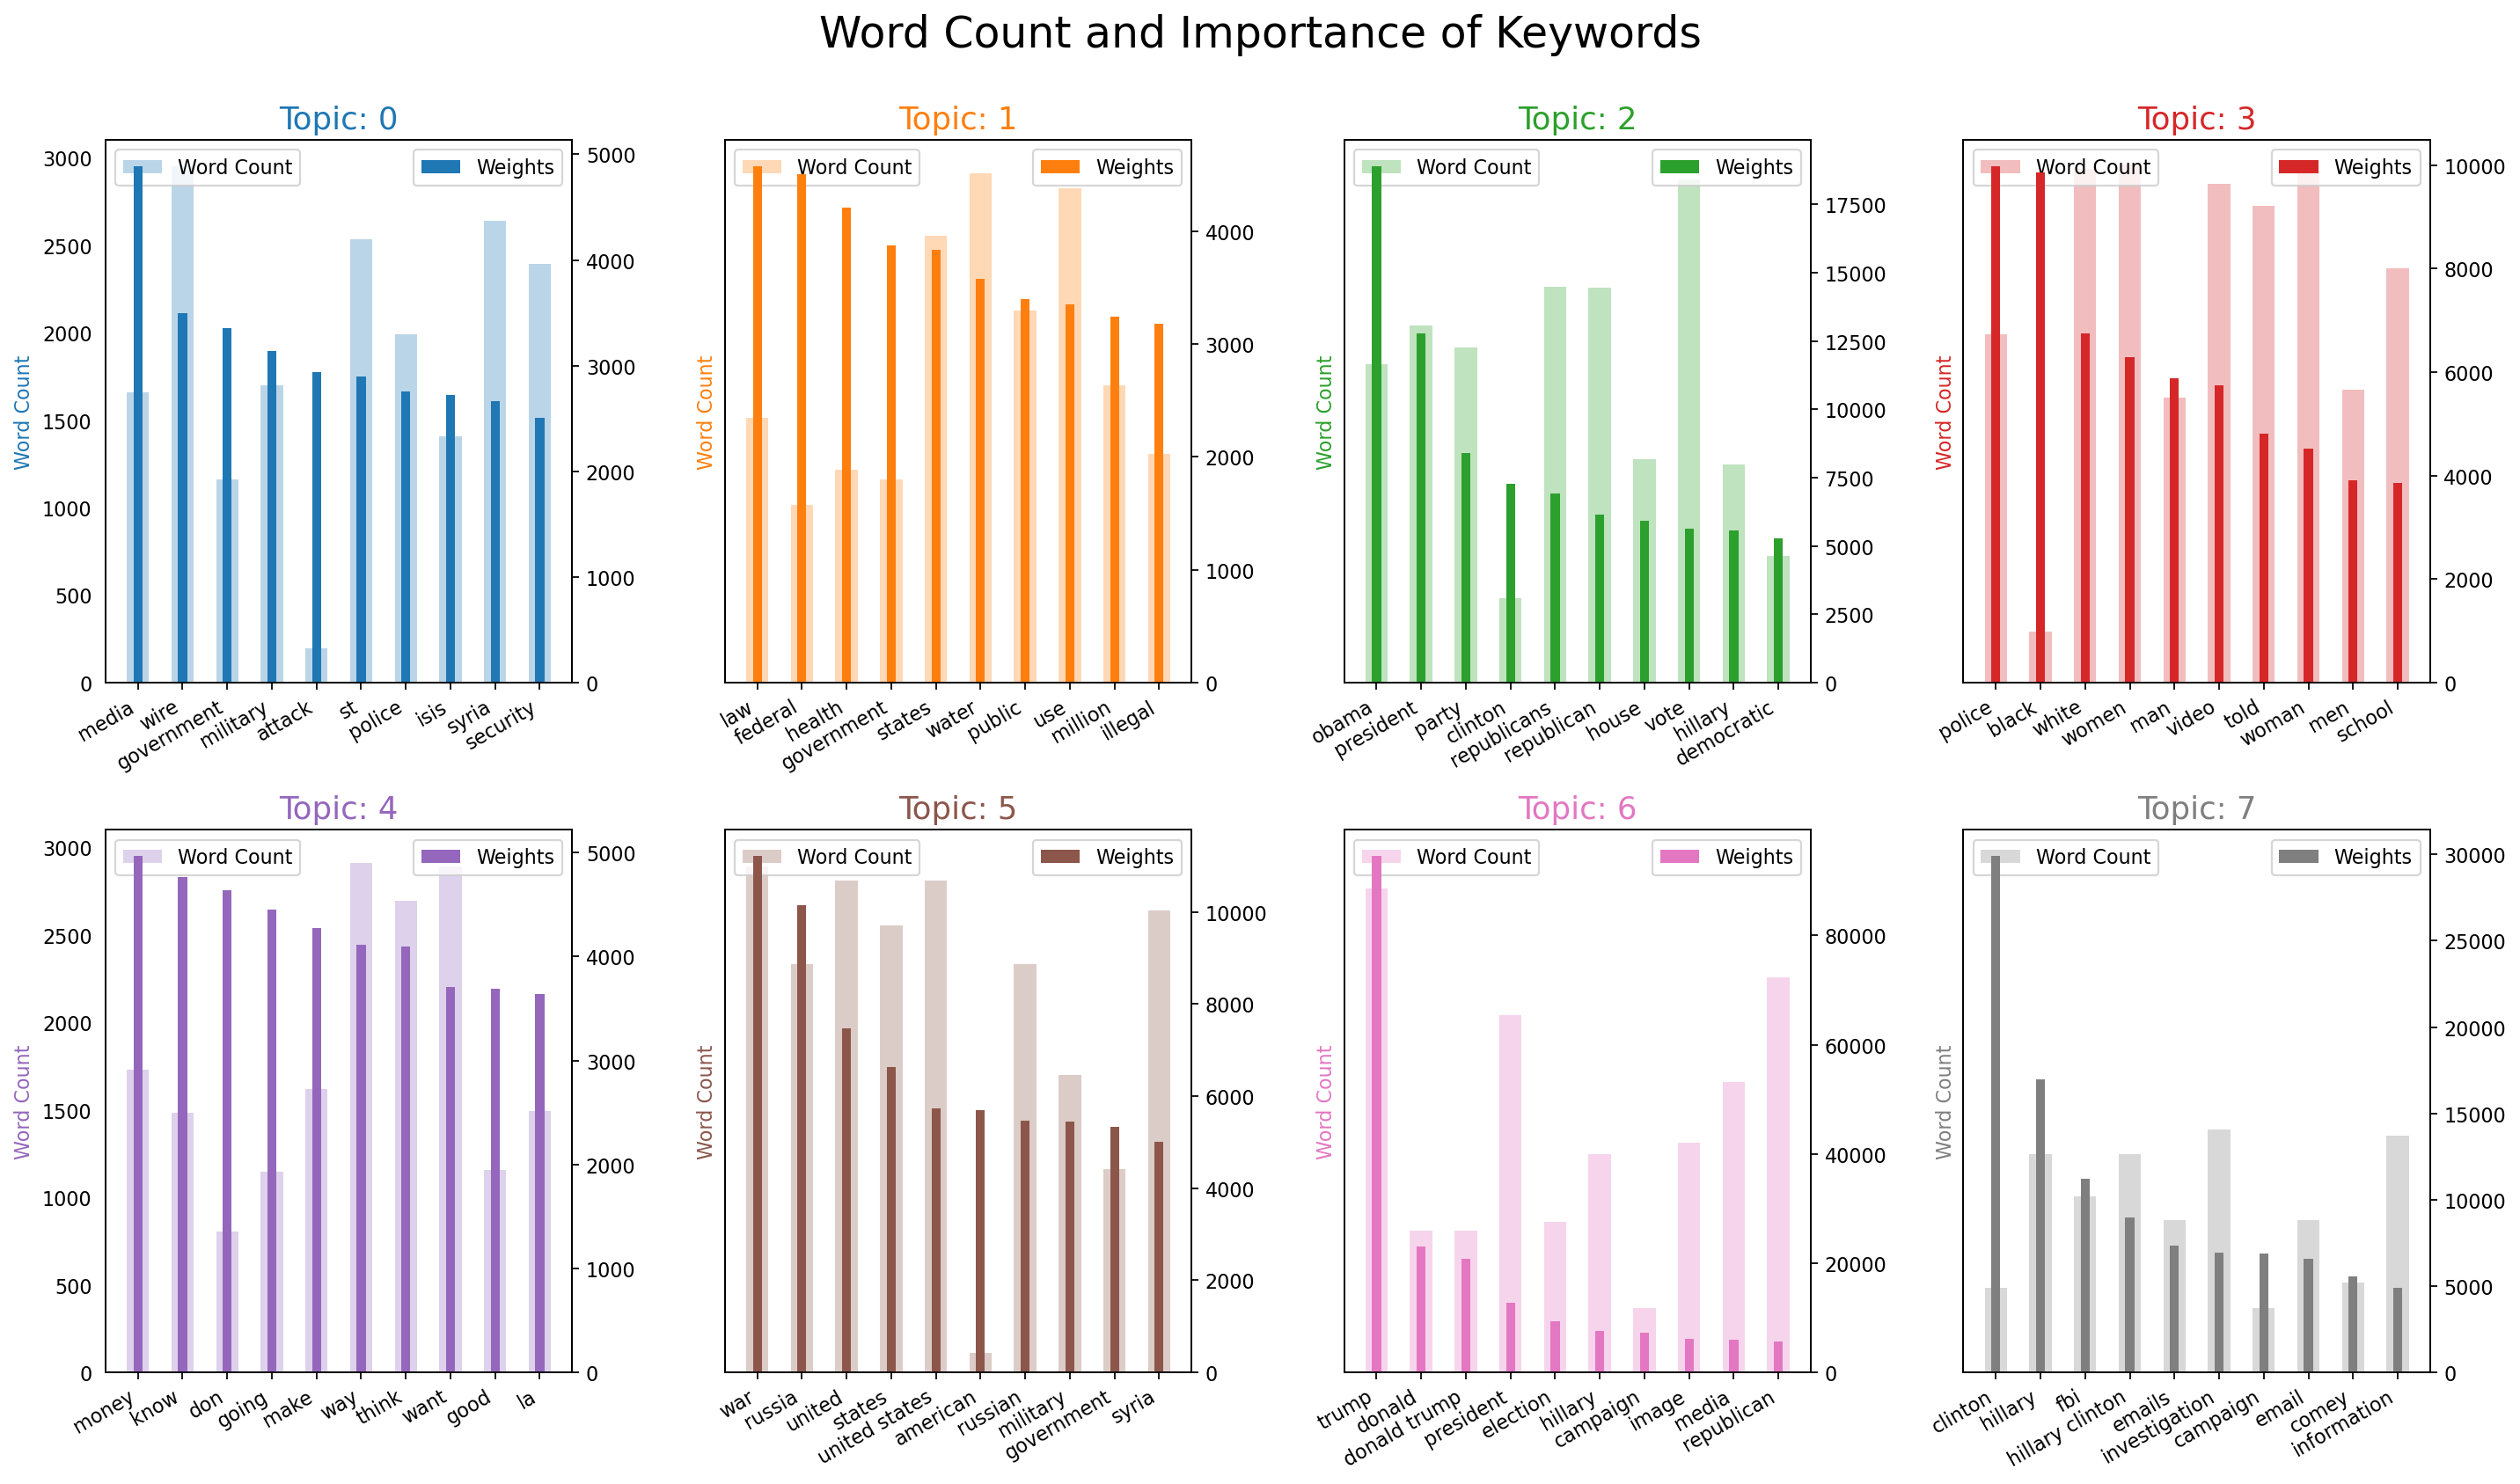

In [225]:
word_count= pd.DataFrame(columns=['topic_id','word','word_count','importance'])
n_top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    top_idx=np.repeat(topic_idx,10)
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [tf_feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    #print(topic_idx,top_features,top_features_ind,weights)
    word_count_i= pd.DataFrame({'topic_id':top_idx,'word':top_features,'word_count':top_features_ind,'importance':weights})
    word_count=pd.concat([word_count,word_count_i],axis=0)
    word_count.sort_values(by='topic_id',ascending=False)
    
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(18,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=word_count.loc[word_count.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=word_count.loc[word_count.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0,); ax.set_ylim(0, )
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(word_count.loc[word_count.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Keywords', fontsize=22, y=1.05)    
plt.show()

In the figure above we can observe the word count and the importance of the keyword for each one of the topics identified.  **Taking topic 0 as an example, which is apparently related with security and military attacks, the word “media” is the most frequent but words as “syria” and “security” are the most relevant** within this topic. 

We can identify 10 different categories of topics using the visualization above and the WordCloud displayed above. The mot 

1. **Topic 0**: Security issues related with military actions, apparently in Syria.  
2. **Topic 1** : Federal laws, apparently related with health care and water use. 
3. **Topic 2** : Political issues, specifically between republican and democrat parties. 
4. **Topic 3**: News related with videos that involve police and black people. 
5. **Topic 4**: News about making money 
6. **Topic 5**: War and military actions which involves Russia 
7. **Topic 6**: Donald Trump, apparently related with presidential elections
8. **Topic 7**: FBI investigations related with Hillary Clinton e-mail controversy



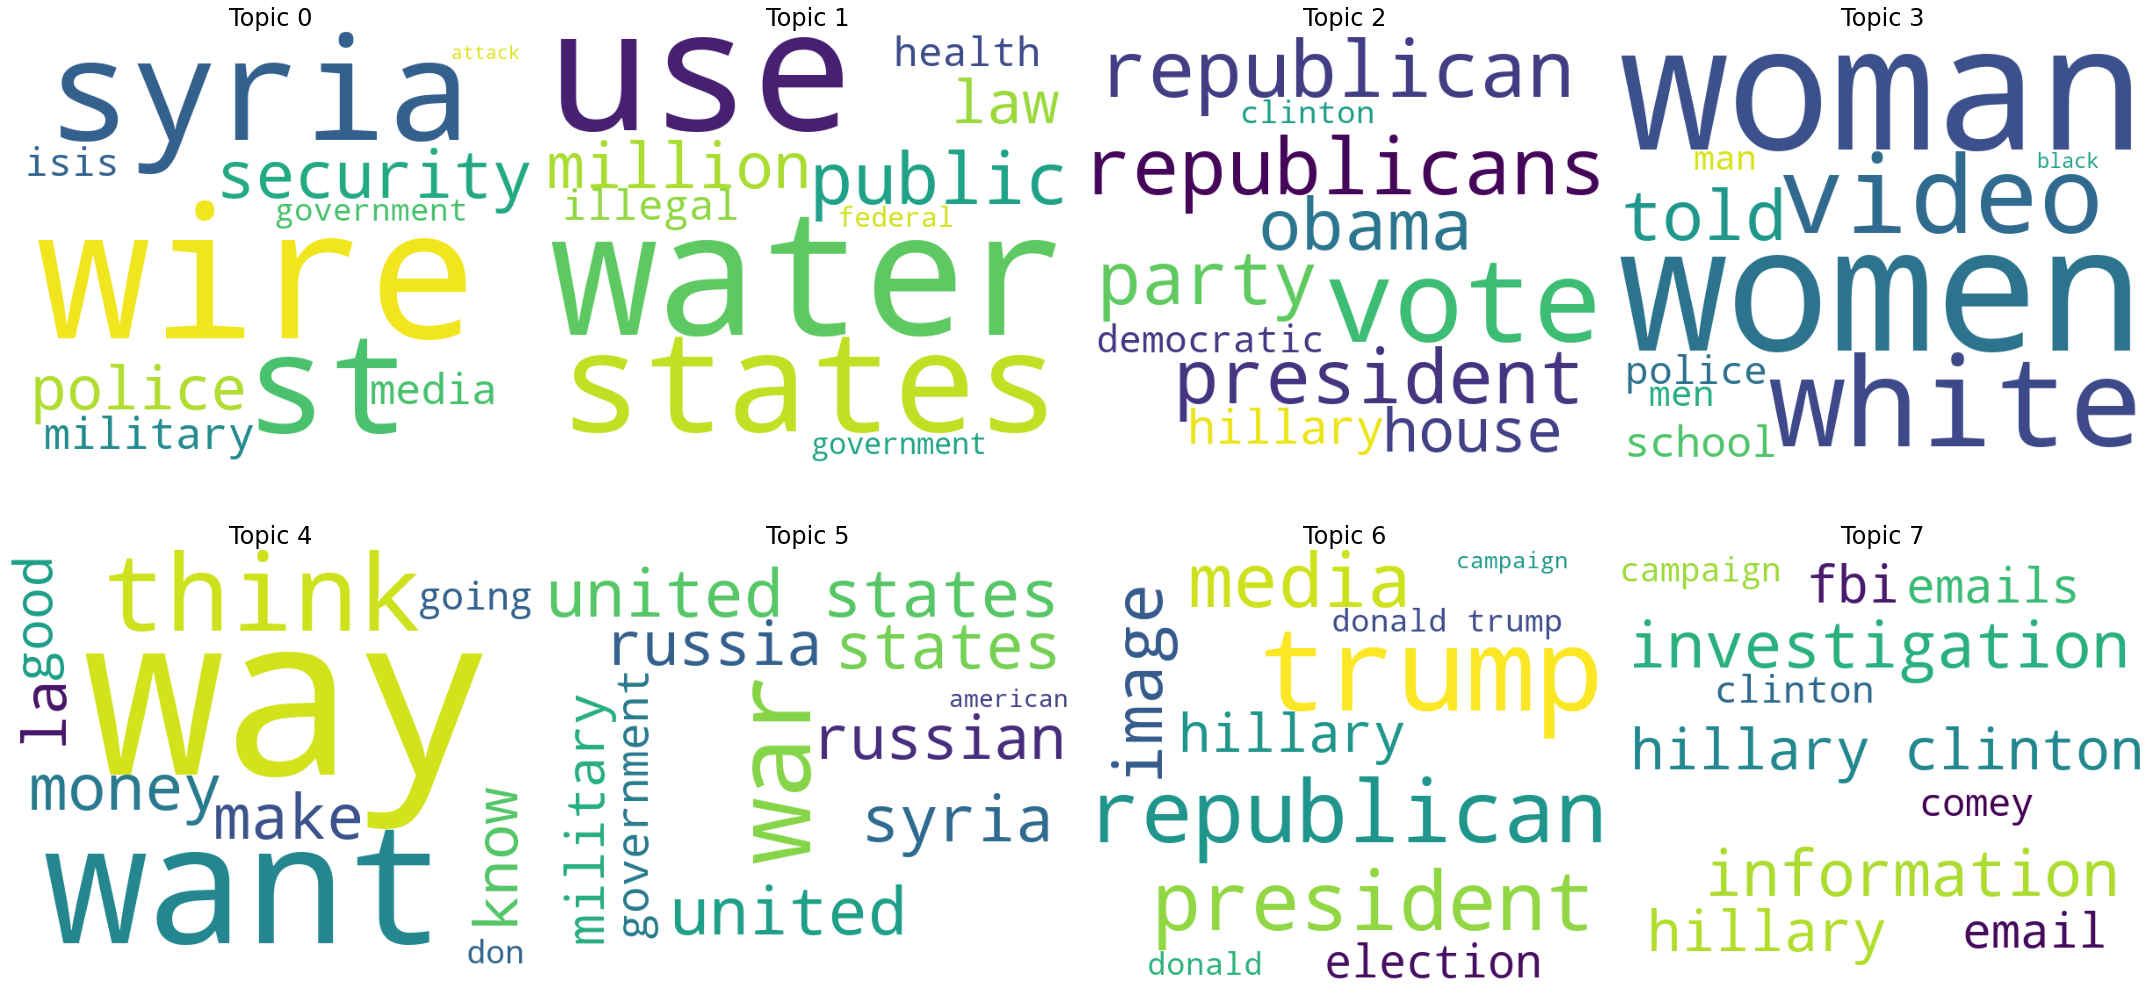

In [226]:
fig, axes = plt.subplots(2, 4, figsize=(30,15), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    dict_word = word_count.loc[word_count.topic_id==i, :].set_index('word').to_dict()['word_count']
    wc = WordCloud(width=600, height=500, max_words=100,background_color='white').generate_from_frequencies(dict_word)
    plt.gca().imshow(wc)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=24))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In the table below we can see the distribution of the topics accross all fake news, the topic 7 related with Hillary Clinton email controversy is the most frequent one, followed by the topic 4 which is related with news about making money.

In [228]:
topics_df = pd.DataFrame()
nb_speeches = classification_df.shape[0]
select = classification_df.columns.str.startswith("Topic ")
topics_df['overall_percentage'] = classification_df.loc[:, select].sum(axis=0) / nb_speeches
topics_df.sort_values(by='overall_percentage', ascending=False)

,overall_percentage
Topic 7,21.030073
Topic 4,17.642998
Topic 5,11.118158
Topic 2,10.972884
Topic 3,10.845354
Topic 8,10.758452
Topic 6,9.796117
Topic 1,7.835965


LDA is a mixture model, meaning it allows for each document to be about multiple topics, and for each word to occur in multiple topics. 

## Topic Assignment

We identified the two main topics per speech based on the weights obtain per component. 

In [229]:
#Choose the main topic
classification_df['main_topic_1']=classification_df.filter(regex=("T.*")).idxmax(axis=1)
classification_df['main_topic_2'] = classification_df.filter(regex=("T.*")).apply(lambda x: x.nlargest(2).index[1], axis=1)
classification_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,main_topic_1,main_topic_2
0,4.477271,0.051101,0.051103,95.216098,0.051113,0.051135,0.051101,0.051079,Topic 4,Topic 1
1,0.695719,0.695865,21.366337,38.427413,0.695835,0.695956,0.695063,36.727812,Topic 4,Topic 8
2,36.797992,0.119240,0.119180,0.119207,0.119192,62.486851,0.119156,0.119182,Topic 6,Topic 1
3,5.225175,55.675302,4.916463,33.586832,0.149076,0.149105,0.149012,0.149034,Topic 2,Topic 4
4,1.390010,1.391270,9.157818,82.497605,1.389494,1.389790,1.393657,1.390355,Topic 4,Topic 3
...,...,...,...,...,...,...,...,...,...,...
36294,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,Topic 1,Topic 2
36295,0.139026,0.139129,0.139117,4.712448,7.652877,0.139057,0.139077,86.939269,Topic 8,Topic 5
36296,11.134431,0.044249,0.044236,81.087610,0.044210,0.044230,6.811945,0.789089,Topic 4,Topic 1
36297,0.055611,5.212825,26.751523,10.301559,0.055640,0.055652,57.511560,0.055628,Topic 7,Topic 3


In the following plot we can see if there is a correspondance between the  frequency of the two main topics within a speech. The bigger the dot, the higher the joint frequency of the topics. 

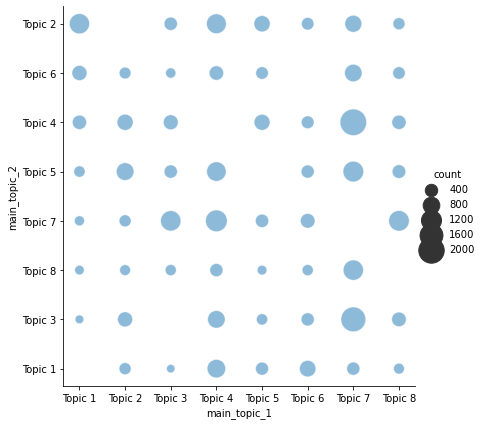

In [233]:
cross_topic_lda=pd.DataFrame(classification_df.groupby(['main_topic_1']).main_topic_2.value_counts().reset_index(name='count'))
sns.relplot(x="main_topic_1", y="main_topic_2", size="count",sizes=(70, 700), alpha=.5,height=6, data=cross_topic_lda)